In [2]:
import os

In [3]:
%pwd

'e:\\dsProject\\nycTaxiProject\\research'

In [4]:
os.chdir("../")

In [5]:
%pwd

'e:\\dsProject\\nycTaxiProject'

In [6]:
# Entity: Data Transformation : It includes the steps to clean, preprocess, and transform the raw data into a format suitable for analysis and modeling. This may involve handling missing values, encoding categorical variables, normalizing numerical features, and creating new features based on domain knowledge. The goal of data transformation is to enhance the quality and usability of the data for subsequent analysis and modeling tasks.
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True) #frozen=True makes the instance of the class immutable, meaning that once an instance is created, its attributes cannot be modified. This is useful for ensuring that the configuration values remain constant throughout the program's execution, preventing accidental changes and enhancing the integrity of the configuration data.
class DataTransformationConfig:
    root_dir:Path
    data_dir:Path
    train: Path
    test: Path
    x_train_dir:Path
    y_train_dir:Path
    x_test_dir:Path
    y_test_dir:Path
    before_encoding:Path
    train_before:Path
    test_before:Path

In [7]:
from nycTaxiProject.constants import CONFIG_FILE_PATH,PARAMS_FILE_PATH
from nycTaxiProject.util.common import read_yaml,create_directories

In [8]:
class ConfigurationManger:
    def __init__(
            self,
            config_filepath=CONFIG_FILE_PATH,
            params_filepath=PARAMS_FILE_PATH):
        self.config=read_yaml(config_filepath)
        self.params=read_yaml(params_filepath)

    def get_data_transformation_config(self) -> DataTransformationConfig:
         config=self.config.data_transformation
         create_directories([config.root_dir])
         create_directories([config.train])
         create_directories([config.test])
         create_directories([config.before_encoding])

         data_transformed_config=DataTransformationConfig(
              root_dir=config.root_dir,
              data_dir=config.data_dir,
              train=config.train,
              test=config.test,
              x_train_dir=config.x_train_dir,
              y_train_dir=config.y_train_dir,
              x_test_dir=config.x_test_dir,
              y_test_dir=config.y_test_dir,
              before_encoding=config.before_encoding,
              train_before=config.train_before,
              test_before=config.test_before
         )
         return data_transformed_config

In [9]:
import pandas as pd
import numpy as np
import logging
logger=logging.getLogger(__name__) # __name__ is a special variable in Python that represents the name of the current module. When a module is run directly, __name__ is set to "__main__". When a module is imported, __name__ is set to the name of the module. By using logging.getLogger(__name__), we can create a logger that is specific to the current module, allowing us to easily identify where log messages are coming from when we have multiple modules in our application.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
class Data_Transformation:
    def __init__(self,config=DataTransformationConfig):
        self.config=config
    # if we assigned in a config argument constructor,& then do we have to pass the config argument while creating the object of this class? No, because we have already assigned a default value to the config argument in the constructor, which is DataTransformationConfig. This means that if we create an object of the Data_Transformation class without passing any arguments, it will use the default value of DataTransformationConfig for the config parameter. However, if we want to use a different configuration, we can pass it as an argument when creating the object.
    def data_transforamtion(self): # do we have to pass config argument here? No, because we have already assigned a default value to the config argument in the constructor, which is DataTransformationConfig. This means that if we call the data_transforamtion method without passing any arguments, it will use the default value of DataTransformationConfig for the config parameter. However, if we want to use a different configuration, we can pass it as an argument when calling the method.
        try:
            data_dir=self.config.data_dir
#  LOAD DATA
            def load_data(df):
                df=pd.read_csv(data_dir)
                df.columns=df.columns.str.lower() # converting all columns to lower case
                logger.info(f"Data Loaded from {data_dir} successfully")
                return df

# FILLING MISSING VALUE
            def filling_missing(df):
                df['passenger_count']=df['passenger_count'].fillna(1)  #after finding mean of this columns we got 1.37 value ,after rounding we're assuming it as 1
                df['congestion_surcharge']=df['congestion_surcharge'].fillna(0)
                df['airport_fee']=df['airport_fee'].fillna(0)
                df['ratecodeid']=df['ratecodeid'].fillna(99) #after investigating thsi column ,we replacing with 9.9(Null/unknown)
                df=df.drop(columns='store_and_fwd_flag') #we're droppoing this columns ,(N:99%+) value.so i could not impact on out predictive model
                logger.info(f"FILLING MISSING VALUES")
                return df

# PREPROCESSING DATE & TIME
            def preprocessingDateTime(df):
                # 1. Convert to datetime using the correct format for your data
                # Using format='ISO8601' handles the "2023-01-01T00:32:10" format automatically
                df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='ISO8601')
                df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='ISO8601')

                # 2. Extract Month and Day of Week
                df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
                df['dropoff_month'] = df['tpep_dropoff_datetime'].dt.month

                df['pickup_dow'] = df['tpep_pickup_datetime'].dt.dayofweek
                df['dropoff_dow'] = df['tpep_dropoff_datetime'].dt.dayofweek

                # 3. Weekend Flag (1 for Sat/Sun, 0 otherwise)
                df['is_weekend'] = df['pickup_dow'].isin([5, 6]).astype(int)

                # 4. Extract Hour (Faster to get as int directly)
                df['pickup_hr'] = df['tpep_pickup_datetime'].dt.hour
                df['dropoff_hr'] = df['tpep_dropoff_datetime'].dt.hour

                # 5. AM/PM Indicator (PM = 1, AM = 0)
                # We can do this based on the hour (>= 12) which is much faster than string parsing
                df['pickup_ampm'] = (df['pickup_hr'] >= 12).astype(int)
                df['dropoff_ampm'] = (df['dropoff_hr'] >= 12).astype(int)

                # 6. Trip duration in minutes
                df['trip_duration_mins'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

                # 7. Filtering minutes
                df=df[(df['trip_duration_mins']>0) & (df['trip_duration_mins']<120)]

                logger.info(f"Preprocessing DateTime completed")
                return df

# DATA CLEANING 
            def data_cleaning(df):
                df=df.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'])
                df[(df['trip_distance']>0.1) & (df['trip_distance']<100)]# because there is no less than 0 trip distance &no such max miles,we simply gave it max 100
                df=df[~df.select_dtypes(include="number").lt(0).any(axis=1)] #it will remove those values  which is less than 0, .lt(0):means less than 0 vlaues

                df=df[df["total_amount"]>3.7]
                df=df[df["total_amount"]<1000]

                df=df[df['payment_type']==1]

                df=df.drop(columns=['total_amount','payment_type','dropoff_month','dropoff_dow','dropoff_ampm','dropoff_hr'])

                # removing 99 cause invalid code
                df=df[df['ratecodeid']<99]
                df=df[df['fare_amount']>=3]
                df=df[df['trip_distance']>0.01]

                df=df[df['passenger_count']>0]
                df=df[df['passenger_count']<=6]

                df=df.drop(columns=['pickup_month'])

                df=df[df['tip_amount']>0]
                df=df[df['fare_amount'] < 200]

                logger.info(f"Data Cleaning completed")
                return df

# FEATURE ENGINEERING
            def feature_engineering(df):
                # adding pre tip amount
                df['pre_tip_amount'] = (
                    df['fare_amount'] + 
                    df['extra'] + 
                    df['mta_tax'] + 
                    df['tolls_amount'] + 
                    df['improvement_surcharge'] + 
                    df['congestion_surcharge'] + 
                    df['airport_fee']
                )
                df=df.drop(columns=['mta_tax','improvement_surcharge']) # dropping these columns as they are not useful for model
                # adding new Flag column based on airport zones  
                aritport_zones=[1,132,138,139] #airport zones
                df['Is_Airport_Trip']=(
                    df['pulocationid'].isin(aritport_zones) | df['dolocationid'].isin(aritport_zones)
                ).astype(int)
                # Flag airport peak hour
                # peak window(4AM-6AM)
                df['is_airport_peak_hour']=df['pickup_hr'].apply(
                    lambda hr:1 if 4<=hr<=6 else 0
                )
                # evening peak hour
                df['is_pm_peak_hour']=df['pickup_hr'].apply(
                    lambda hr:1 if 16<=hr<=18 else 0) 
                # calculating avg speed of trip     [avg_speed = trip_distance / trip_duration_mins]
                df['avg_speed']=df['trip_distance']/df['trip_duration_mins']
                df=df[df['avg_speed'] < 60]
                
                # Fare per mile
                df['farePerMile']=df['fare_amount']/df['trip_distance']
                df=df[df['farePerMile'] < 50]

                # pickup hr to cynical feature
                # 1. Create Sine and Cosine features
                df['PickUpHr_sin'] = np.sin(2 * np.pi * df['pickup_hr'] / 24.0)
                df['PickUpHr_cos'] = np.cos(2 * np.pi * df['pickup_hr'] / 24.0)
                # 2. Drop the original linear hour column
                df.drop(columns=['pickup_hr'], inplace=True)
                # df=df[df['ratecodeid']==1] # we are only taking ratecodeid 1 because it is the most common rate code and it will help us to reduce the noise in our data(Consistent data)
                
                logger.info(f"Feature Engineering completed")
                return df
    
    # TRAIN - TEST SPLIT 20%
            def train_test_split(df) -> pd.DataFrame:
                test_size=int(len(df)*0.2)
                # shuffling our data
                df=df.sample(frac=1,random_state=432).reset_index(drop=True)

                # selecting trining & target columns
                target=df['tip_amount']
                features=df.drop(columns=['tip_amount'])

                # reserve all but the last 1000000 rows for training - anything else for testing
                x_train,x_test=features.iloc[:-test_size],features.iloc[-test_size:]
                y_train,y_test=target.iloc[:-test_size],target.iloc[-test_size:]

                logger.info(f"Train-Test Split completed with test size: {test_size}")
                return x_train,x_test,y_train,y_test
    
    # CLIPPING OUTLIERS on INDEPENDENT VARIABLE   (x_train,x_test)
            def clipping_independent(x_train,x_test)->pd.DataFrame:
                # clipping on 99.5th percentile to remove extreme outliers
                fare_cap = x_train['fare_amount'].quantile(0.995)
                dist_cap = x_train['trip_distance'].quantile(0.995)
                # clip the values in the columns to the respective caps
                x_train['fare_amount']=x_train['fare_amount'].clip(upper=fare_cap)
                x_train['trip_distance']=x_train['trip_distance'].clip(upper=dist_cap)

                x_test['fare_amount']=x_test['fare_amount'].clip(upper=fare_cap)
                x_test['trip_distance']=x_test['trip_distance'].clip(upper=dist_cap)

                logger.info(f"Clipping Outliers completed")
                return x_train,x_test

    # ENCODDING Independent variable
            def encoding_independent(x_train,x_test,y_train):
                # 1. Define Features (Same as before)
                cat_onehot_features = ['vendorid','ratecodeid', 'pickup_dow']
                cat_target_features = ['pulocationid', 'dolocationid']
                numerical_features = [
                    'passenger_count', 'extra', 'tolls_amount', 
                    'congestion_surcharge', 'airport_fee', 
                    'trip_distance', 'fare_amount', 'farePerMile',
                     'pre_tip_amount','avg_speed','trip_duration_mins'
                ]

                #2. Column Transformer
                preprocessor=ColumnTransformer(
                    transformers=[
                        ('onehot',OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False),cat_onehot_features),
                        ('target',TargetEncoder(smooth="auto", target_type='continuous'),cat_target_features),
                        ('standardScaler',StandardScaler(),numerical_features)
                    ]
                )
                # preprocessor.set_output(transform="pandas") # magic line for turning into dataframe
                # fit & transform the training data
                x_trainEncoded=preprocessor.fit_transform(x_train,y_train)

                # fit & transform the training data
                x_testEncoded=preprocessor.transform(x_test)

                # After fit_transform
                names = preprocessor.get_feature_names_out()
                encoded_train = pd.DataFrame(x_trainEncoded, columns=names, index=x_train.index)
                encoded_test = pd.DataFrame(x_testEncoded, columns=names, index=x_test.index)

                # combining some columns which were not transformed by column transformer
                # non_transformed_cols = [col for col in x_train.columns if col not in names]
                # encoded_train = pd.concat([encoded_train, x_train[non_transformed_cols]], axis=1)
                # encoded_test = pd.concat([encoded_test, x_test[non_transformed_cols]], axis=1)

                addidtional_cols=['is_weekend', 'pickup_ampm','Is_Airport_Trip', 'is_airport_peak_hour', 'is_pm_peak_hour','PickUpHr_sin', 'PickUpHr_cos']
                encoded_train = pd.concat([encoded_train, x_train[addidtional_cols]], axis=1)
                encoded_test = pd.concat([encoded_test, x_test[addidtional_cols]], axis=1)

                return encoded_train,encoded_test
            
    #SAVING BEFORE ENCODING DATA
            def save_before_encoding(x_train,x_test):
                train_before_dir=self.config.train_before
                test_before_dir=self.config.test_before

                x_train.to_csv(train_before_dir,index=False)
                x_test.to_csv(test_before_dir,index=False)

                logger.info(f"Before Encoding data saved at {self.config.before_encoding} successfully...")

    # SAVING Complete TRANSFORMED DATA
            def save_transformed_data(x_train,x_test,y_train,y_test):
                transformed_data_dir=self.config.root_dir
                x_train_dir=self.config.x_train_dir
                y_train_dir=self.config.y_train_dir
                x_test_dir=self.config.x_test_dir
                y_test_dir=self.config.y_test_dir

                x_train.to_csv(x_train_dir,index=False)
                y_train.to_csv(y_train_dir,index=False)
                x_test.to_csv(x_test_dir,index=False)
                y_test.to_csv(y_test_dir,index=False)

                logger.info(f"Trasnfomred data saved at {transformed_data_dir} successfully...")
                
                 


    # calling all FUNCTIONS
            df=load_data(data_dir) #loading data
            df=filling_missing(df) #filling missing value
            df=preprocessingDateTime(df)  # preprocessing data & time
            df=data_cleaning(df)# data cleaning
            df=feature_engineering(df) #feature Engineering
            x_train,x_test,y_train,y_test=train_test_split(df) # train test split
            x_train,x_test=clipping_independent(x_train,x_test) # cipping outliers on x variavles
            save_before_encoding(x_train,x_test) # saving before encoding data
            x_train,x_test=encoding_independent(x_train,x_test,y_train) #encoding train-test spit
            save_transformed_data(x_train,x_test,y_train,y_test) # saving transformed data
    
            


        except Exception as e:
            logger.error(f"Error in data transformation: {e}")
            raise e

In [11]:
try:
    logger.info(">>>>>>>STAGE: DATA TRANSFORMATION STARTED<<<<<<<<< ")
    config=ConfigurationManger()
    data_transformed_config=config.get_data_transformation_config()
    data_transform=Data_Transformation(config=data_transformed_config)
    data_transform.data_transforamtion()
    logger.info(">>>>>>>STAGE: DATA TRANSFORMATION ENDED<<<<<<<<< ")

except Exception as e:
    logger.exception(e)
    raise e

[2026-02-25 01:59:53,695 : INFO : 4138332530 : >>>>>>>STAGE: DATA TRANSFORMATION STARTED<<<<<<<<< ]
[2026-02-25 01:59:53,722 : INFO : common : yaml file: config\config.yaml LOADED successfully]
[2026-02-25 01:59:53,737 : INFO : common : yaml file: params.yaml LOADED successfully]
[2026-02-25 01:59:53,746 : INFO : common : created directory at: artifacts/data_transformation]
[2026-02-25 01:59:53,750 : INFO : common : created directory at: artifacts/data_transformation/train]
[2026-02-25 01:59:53,759 : INFO : common : created directory at: artifacts/data_transformation/test]
[2026-02-25 01:59:53,766 : INFO : common : created directory at: artifacts/data_transformation/before_encoding]
[2026-02-25 02:00:00,139 : INFO : 2778395237 : Data Loaded from artifacts/data_ingestion/data.csv successfully]
[2026-02-25 02:00:00,579 : INFO : 2778395237 : FILLING MISSING VALUES]
[2026-02-25 02:00:05,116 : INFO : 2778395237 : Preprocessing DateTime completed]
[2026-02-25 02:00:08,493 : INFO : 2778395237

### Data Transformation
* Data filling 
* Data cleaning(FILTER)
* Data-Time Preprocessing
* Train-Test split
* Feature Engineering 
* Capping (99%)
* Encoding
* SAVING TRAIN & TEST CSV

In [12]:
x_train=pd.read_csv("artifacts/data_transformation/train/x_train.csv")
x_test=pd.read_csv("artifacts/data_transformation/test/x_test.csv")
y_train=pd.read_csv("artifacts/data_transformation/train/y_train.csv")  
y_test=pd.read_csv("artifacts/data_transformation/test/y_test.csv")

In [16]:
pd.set_option('display.max_columns', None)

In [17]:
print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")

X_train shape: (285460, 31)
X_test shape: (71364, 31)


In [18]:
x_train.head()

,onehot__vendorid_2,onehot__ratecodeid_2.0,onehot__ratecodeid_3.0,onehot__ratecodeid_4.0,onehot__ratecodeid_5.0,onehot__pickup_dow_1,onehot__pickup_dow_2,onehot__pickup_dow_3,onehot__pickup_dow_4,onehot__pickup_dow_5,onehot__pickup_dow_6,target__pulocationid,target__dolocationid,standardScaler__passenger_count,standardScaler__extra,standardScaler__tolls_amount,standardScaler__congestion_surcharge,standardScaler__airport_fee,standardScaler__trip_distance,standardScaler__fare_amount,standardScaler__farePerMile,standardScaler__pre_tip_amount,standardScaler__avg_speed,standardScaler__trip_duration_mins,is_weekend,pickup_ampm,Is_Airport_Trip,is_airport_peak_hour,is_pm_peak_hour,PickUpHr_sin,PickUpHr_cos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.298864,3.924521,-0.455054,0.436307,-0.29293,0.262919,-0.344822,-0.243333,-0.137761,-0.183867,-0.114293,-0.222270,0.192908,0,1,0,0,0,-9.659258e-01,2.588190e-01
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.525001,3.953664,-0.455054,0.436307,-0.29293,0.262919,-0.344822,-0.221947,-0.056299,-0.078328,-0.043073,-0.192892,0.166694,0,1,0,0,0,1.224647e-16,-1.000000e+00
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.504472,5.213303,-0.455054,-0.362960,-0.29293,0.262919,-0.344822,0.229285,0.228820,-0.830957,0.129890,0.348146,0.012495,0,1,0,0,0,-7.071068e-01,7.071068e-01
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.676536,3.757323,-0.455054,-0.895805,-0.29293,0.262919,-0.344822,-0.579084,-0.626537,0.507777,-0.668791,-0.275088,-0.673693,0,0,0,0,0,8.660254e-01,-5.000000e-01
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.737986,7.853063,-0.455054,0.436307,-0.29293,-3.803448,2.900043,2.570988,2.469040,-1.183359,2.101156,0.702947,2.029424,0,1,1,0,1,-1.000000e+00,-1.836970e-16


## Doing some research on befeore encoding

In [23]:
before_encoding=pd.read_csv("artifacts/data_transformation/before_encoding/x_train_bEncode.csv")
before_encoding.head()

,vendorid,passenger_count,trip_distance,ratecodeid,pulocationid,dolocationid,fare_amount,extra,tolls_amount,congestion_surcharge,airport_fee,pickup_dow,is_weekend,pickup_ampm,trip_duration_mins,pre_tip_amount,Is_Airport_Trip,is_airport_peak_hour,is_pm_peak_hour,avg_speed,farePerMile,PickUpHr_sin,PickUpHr_cos
0,2,1.0,2.60,1.0,263,239,17.0,2.5,0.0,2.5,0.00,4,0,1,16.750000,23.50,0,0,0,0.155224,6.538462,-9.659258e-01,2.588190e-01
1,1,1.0,2.70,1.0,230,239,18.4,2.5,0.0,2.5,0.00,2,0,1,16.466667,24.90,0,0,0,0.163968,6.814815,1.224647e-16,-1.000000e+00
2,2,1.0,4.81,1.0,234,88,23.3,1.0,0.0,2.5,0.00,3,0,1,14.800000,28.30,0,0,0,0.325000,4.844075,-7.071068e-01,7.071068e-01
3,2,1.0,1.03,1.0,162,170,8.6,0.0,0.0,2.5,0.00,2,0,0,7.383333,12.60,0,0,0,0.139503,8.349515,8.660254e-01,-5.000000e-01
4,2,1.0,15.76,1.0,132,112,61.8,2.5,0.0,0.0,1.25,3,0,1,36.600000,67.05,1,0,1,0.430601,3.921320,-1.000000e+00,-1.836970e-16


In [24]:
before_encoding['ratecodeid'].agg(['min','max','mean'])

min     1.000000
max     5.000000
mean    1.066836
Name: ratecodeid, dtype: float64

In [25]:
x_train.agg(['min','max','mean']).T

,min,max,mean
onehot__vendorid_2,0.000000,1.000000,7.506306e-01
onehot__ratecodeid_2.0,0.000000,1.000000,4.984937e-02
onehot__ratecodeid_3.0,0.000000,1.000000,3.268409e-03
onehot__ratecodeid_4.0,0.000000,1.000000,1.166538e-03
onehot__ratecodeid_5.0,0.000000,1.000000,1.737546e-03
onehot__pickup_dow_1,0.000000,1.000000,1.652701e-01
onehot__pickup_dow_2,0.000000,1.000000,1.884572e-01
onehot__pickup_dow_3,0.000000,1.000000,2.045786e-01
onehot__pickup_dow_4,0.000000,1.000000,1.780460e-01
onehot__pickup_dow_5,0.000000,1.000000,5.955300e-05


In [26]:
before_encoding.agg(['min','max','mean']).T

,min,max,mean
vendorid,1.000000,2.000000,1.750631
passenger_count,1.000000,6.000000,1.413613
trip_distance,0.070000,21.897050,3.737844
ratecodeid,1.000000,5.000000,1.066836
pulocationid,1.000000,265.000000,167.580645
dolocationid,1.000000,265.000000,165.755549
fare_amount,3.000000,87.400000,19.367538
extra,0.000000,11.250000,1.681174
tolls_amount,0.000000,61.150000,0.628548
congestion_surcharge,0.000000,2.500000,2.338357


### Insight
* remove 'ratecodeid' ,make no sence for single data value '1' 
* 

In [27]:
before_encoding[before_encoding['avg_speed']>1].count()

vendorid                67
passenger_count         67
trip_distance           67
ratecodeid              67
pulocationid            67
dolocationid            67
fare_amount             67
extra                   67
tolls_amount            67
congestion_surcharge    67
airport_fee             67
pickup_dow              67
is_weekend              67
pickup_ampm             67
trip_duration_mins      67
pre_tip_amount          67
Is_Airport_Trip         67
is_airport_peak_hour    67
is_pm_peak_hour         67
avg_speed               67
farePerMile             67
PickUpHr_sin            67
PickUpHr_cos            67
dtype: int64

In [28]:
before_encoding['farePerMile'].agg(['min','max','mean','std'])

min      0.189744
max     49.295775
mean     7.019913
std      2.618477
Name: farePerMile, dtype: float64

In [29]:
before_encoding[before_encoding['farePerMile']>100].count()

vendorid                0
passenger_count         0
trip_distance           0
ratecodeid              0
pulocationid            0
dolocationid            0
fare_amount             0
extra                   0
tolls_amount            0
congestion_surcharge    0
airport_fee             0
pickup_dow              0
is_weekend              0
pickup_ampm             0
trip_duration_mins      0
pre_tip_amount          0
Is_Airport_Trip         0
is_airport_peak_hour    0
is_pm_peak_hour         0
avg_speed               0
farePerMile             0
PickUpHr_sin            0
PickUpHr_cos            0
dtype: int64

In [30]:
before_encoding[before_encoding['farePerMile']<50].count()

vendorid                285460
passenger_count         285460
trip_distance           285460
ratecodeid              285460
pulocationid            285460
dolocationid            285460
fare_amount             285460
extra                   285460
tolls_amount            285460
congestion_surcharge    285460
airport_fee             285460
pickup_dow              285460
is_weekend              285460
pickup_ampm             285460
trip_duration_mins      285460
pre_tip_amount          285460
Is_Airport_Trip         285460
is_airport_peak_hour    285460
is_pm_peak_hour         285460
avg_speed               285460
farePerMile             285460
PickUpHr_sin            285460
PickUpHr_cos            285460
dtype: int64

In [31]:
before_encoding['farePerMile'].value_counts().sort_index()

farePerMile
0.189744     1
0.433895     1
0.576923     1
0.681818     1
0.750000     1
            ..
48.611111    1
48.888889    1
48.951049    2
49.245283    1
49.295775    2
Name: count, Length: 25890, dtype: int64

In [32]:
before_encoding['trip_distance'].value_counts().sort_index()

trip_distance
0.07000        4
0.08000        4
0.09000        5
0.10000       42
0.11000       10
            ... 
21.86000       5
21.87000       3
21.88000       6
21.89000       8
21.89705    1428
Name: count, Length: 2184, dtype: int64

In [33]:
before_encoding['trip_distance'].agg(['min','max','mean'])

min      0.070000
max     21.897050
mean     3.737844
Name: trip_distance, dtype: float64

In [34]:
before_encoding[before_encoding['trip_distance']<1].value_counts()

vendorid  passenger_count  trip_distance  ratecodeid  pulocationid  dolocationid  fare_amount  extra  tolls_amount  congestion_surcharge  airport_fee  pickup_dow  is_weekend  pickup_ampm  trip_duration_mins  pre_tip_amount  Is_Airport_Trip  is_airport_peak_hour  is_pm_peak_hour  avg_speed  farePerMile  PickUpHr_sin  PickUpHr_cos
2         1.0              0.37           1.0         237           237           5.1          0.0    0.0           2.5                   0.0          1           0           1            3.533333            9.1             0                0                     0                0.104717   13.783784    -0.258819     -0.965926       2
1         1.0              0.80           1.0         236           237           7.9          2.5    0.0           2.5                   0.0          4           0           0            9.000000            14.4            0                0                     0                0.088889   9.875000      0.500000     -0.866025      

In [35]:
before_encoding['ratecodeid'].value_counts()

ratecodeid
1.0    269468
2.0     14230
3.0       933
5.0       496
4.0       333
Name: count, dtype: int64

In [36]:
before_encoding[before_encoding['trip_distance']>21.4].count()

vendorid                1830
passenger_count         1830
trip_distance           1830
ratecodeid              1830
pulocationid            1830
dolocationid            1830
fare_amount             1830
extra                   1830
tolls_amount            1830
congestion_surcharge    1830
airport_fee             1830
pickup_dow              1830
is_weekend              1830
pickup_ampm             1830
trip_duration_mins      1830
pre_tip_amount          1830
Is_Airport_Trip         1830
is_airport_peak_hour    1830
is_pm_peak_hour         1830
avg_speed               1830
farePerMile             1830
PickUpHr_sin            1830
PickUpHr_cos            1830
dtype: int64

# Model training

In [37]:
print(f"AFTER ENCODING COLUMNS: {x_train.columns} ")
print(f"BEFORE ENCODING COLUMNS: {before_encoding.columns} ")

AFTER ENCODING COLUMNS: Index(['onehot__vendorid_2', 'onehot__ratecodeid_2.0',
       'onehot__ratecodeid_3.0', 'onehot__ratecodeid_4.0',
       'onehot__ratecodeid_5.0', 'onehot__pickup_dow_1',
       'onehot__pickup_dow_2', 'onehot__pickup_dow_3', 'onehot__pickup_dow_4',
       'onehot__pickup_dow_5', 'onehot__pickup_dow_6', 'target__pulocationid',
       'target__dolocationid', 'standardScaler__passenger_count',
       'standardScaler__extra', 'standardScaler__tolls_amount',
       'standardScaler__congestion_surcharge', 'standardScaler__airport_fee',
       'standardScaler__trip_distance', 'standardScaler__fare_amount',
       'standardScaler__farePerMile', 'standardScaler__pre_tip_amount',
       'standardScaler__avg_speed', 'standardScaler__trip_duration_mins',
       'is_weekend', 'pickup_ampm', 'Is_Airport_Trip', 'is_airport_peak_hour',
       'is_pm_peak_hour', 'PickUpHr_sin', 'PickUpHr_cos'],
      dtype='str') 
BEFORE ENCODING COLUMNS: Index(['vendorid', 'passenger_count', '

##### MISSING COLUMNS IN Encoded dataset
'is_weekend', 'pickup_ampm','Is_Airport_Trip', 'is_airport_peak_hour', 'is_pm_peak_hour','avg_speed','PickUpHr_sin', 'PickUpHr_cos'

In [13]:
from sklearn.linear_model import SGDRegressor

regressor=SGDRegressor(
            loss='squared_error',
            penalty='l2',
            alpha=0.01,           # Stronger regularization
            max_iter=5000,
            tol=1e-3,
            random_state=42,
            learning_rate='adaptive', 
            eta0=0.001
        )

model=regressor.fit(x_train,y_train)

e:\dsProject\nycTaxiProject\venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def evaluate_model(model, X, y_true, name):
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"-----------{name} Evaluation-------------")
    print(f"R2 Score:   {r2:.4f}")
    print(f"RMSE:       {rmse:.4f}")
    print(f"MAE:        {mae:.4f}")

In [15]:
evaluate_model(model, x_train, y_train, "Training")
evaluate_model(model, x_test, y_test, "Testing")

-----------Training Evaluation-------------
R2 Score:   0.6906
RMSE:       2.2370
MAE:        1.1405
-----------Testing Evaluation-------------
R2 Score:   0.7187
RMSE:       2.0790
MAE:        1.1287


In [40]:
evaluate_model(model, x_train, y_train, "Training")
evaluate_model(model, x_test, y_test, "Testing")

-----------Training Evaluation-------------
R2 Score:   0.6906
RMSE:       2.2370
MAE:        1.1407
-----------Testing Evaluation-------------
R2 Score:   0.7187
RMSE:       2.0790
MAE:        1.1288


In [41]:
# feature importance
coefficents=model.coef_
feature_names=x_train.columns
feature_importance=pd.DataFrame({
    'Feature':feature_names,
    'Coefficient':coefficents
}).sort_values(by='Coefficient',key=abs,ascending=False)
feature_importance

,Feature,Coefficient
21,standardScaler__pre_tip_amount,1.395949
19,standardScaler__fare_amount,1.073141
0,onehot__vendorid_2,0.458214
15,standardScaler__tolls_amount,0.263954
23,standardScaler__trip_duration_mins,0.257921
18,standardScaler__trip_distance,0.234903
14,standardScaler__extra,0.197984
1,onehot__ratecodeid_2.0,-0.130935
12,target__dolocationid,0.096380
28,is_pm_peak_hour,-0.089057


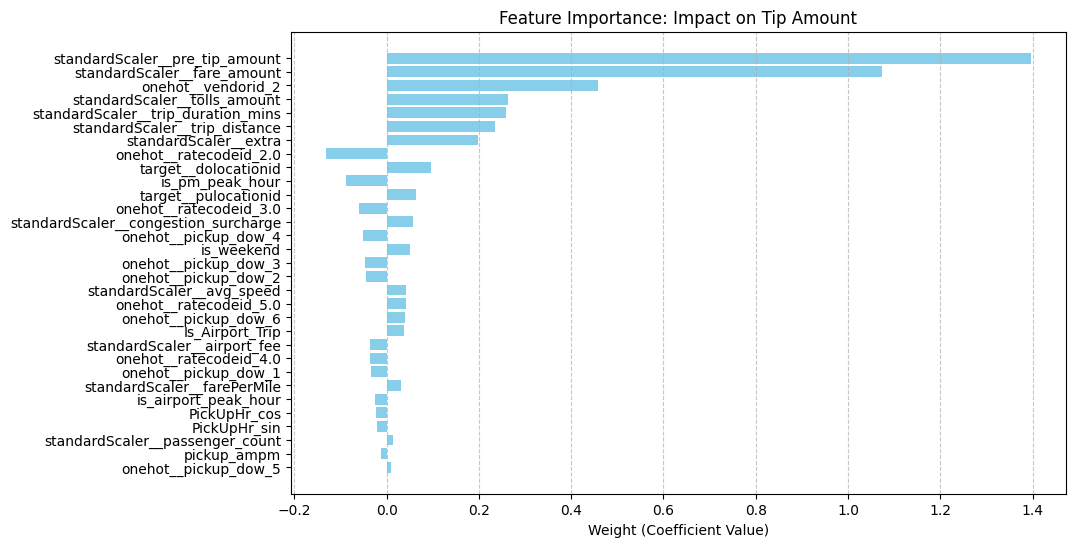

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plotting top 15 features
top_features = feature_importance
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel("Weight (Coefficient Value)")
plt.title("Feature Importance: Impact on Tip Amount")
plt.gca().invert_yaxis() # Put the most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
